In [1]:
import sys
print(sys.version)

CURR_DIR = '/content/drive/My Drive/google_colab_work/advanced_deep_learning_by_pytorch/'
CURR_DIR += '3_semantic_segmentation/'
sys.path.append(CURR_DIR)

3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]


In [2]:
import os.path
import PIL.Image
import random
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
print('torch.__version__ =', torch.__version__)


from utils.data_augumentation import Compose, Scale, RandomRotation, RandomMirror, Resize, Normalize_Tensor

torch.__version__ = 1.6.0+cu101


In [3]:
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

# DataLoader

In [4]:
def MakeDatapathList(root_path):
    img_path_template = os.path.join(root_path, 'JPEGImages', '%s.jpg')
    anno_path_template = os.path.join(root_path, 'SegmentationClass', '%s.png')

    train_id_names = os.path.join(root_path + 'ImageSets/Segmentation/train.txt')
    val_id_names = os.path.join(root_path + 'ImageSets/Segmentation/val.txt')

    train_img_list = []
    train_anno_list = []
    for line in open(train_id_names):
        file_id = line.strip()
        img_path = (img_path_template % file_id)
        anno_path = (anno_path_template % file_id)
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)

    val_img_list = []
    val_anno_list = []
    for line in open(val_id_names):
        file_id = line.strip()
        img_path = (img_path_template % file_id)
        anno_path = (anno_path_template % file_id)
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)

    return train_img_list, train_anno_list, val_img_list, val_anno_list

In [5]:
class DataTransform():
    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            'train': Compose([
                Scale(scale=[0.5, 1.5]),
                RandomRotation(angle=[-10, 10]), # [deg]
                RandomMirror(),
                Resize(input_size),
                Normalize_Tensor(color_mean, color_std) ### PIL(h, w, c) ---> Torch(c, h, w)
            ]),
            'val': Compose([
                Resize(input_size),
                Normalize_Tensor(color_mean, color_std)
            ])
        }


    def __call__(self, phase, img, anno_class_img):
        return self.data_transform[phase](img, anno_class_img)

In [6]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, anno_list, phase, data_transform):
        assert len(img_list) == len(anno_list)
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.data_transform = data_transform

    
    def __len__(self):
        return len(self.img_list)


    def __getitem__(self, idx):
        img, anno_class_img = self.RetrieveItem(idx)
        return img, anno_class_img 


    def RetrieveItem(self, idx):
        img_file_path = self.img_list[idx]
        img = PIL.Image.open(img_file_path) ### (h, w, c=RGB)

        anno_file_path = self.anno_list[idx]
        anno_class_img = PIL.Image.open(anno_file_path) ### (h, w)

        img, anno_class_img = self.data_transform(self.phase, img, anno_class_img)
        return img, anno_class_img 

# Feature module (Encoder)

In [7]:
class ConvBatchNormRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)


    def forward(self, x):
        outputs = self.conv(x)
        outputs = self.batchnorm(outputs)
        outputs = self.relu(outputs)

        return outputs

In [8]:
class FeatureMapConv(nn.Module):
    def __init__(self):
        super().__init__()

        in_channels=3; out_channels=64; kernel_size=3; stride=2; padding=1; dilation=1; bias=False
        self.cbnr_1 = ConvBatchNormRelu(in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        in_channels=64; out_channels=64; kernel_size=3; stride=1; padding=1; dilation=1; bias=False
        self.cbnr_2 = ConvBatchNormRelu(in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        in_channels=64; out_channels=128; kernel_size=3; stride=1; padding=1; dilation=1; bias=False
        self.cbnr_3 = ConvBatchNormRelu(in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        kernel_size=3; stride=2; padding=1 
        self.maxpool = nn.MaxPool2d(kernel_size, stride, padding)


    def forward(self, x):
        outputs = self.cbnr_1(x)
        outputs = self.cbnr_2(outputs)
        outputs = self.cbnr_3(outputs)
        outputs = self.maxpool(outputs)

        return outputs

In [9]:
class ConvBatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)


    def forward(self, x):
        outputs = self.conv(x)
        outputs = self.batchnorm(outputs)

        return outputs

In [10]:
class BottleNeckPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride, dilation):
        assert in_channels == 2*mid_channels
        assert 4*mid_channels == out_channels

        super().__init__()

        self.cbr_1 = ConvBatchNormRelu(in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = ConvBatchNormRelu(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = ConvBatchNorm(mid_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.cb_residual = ConvBatchNorm(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, dilation=1, bias=False)

        self.relu = nn.ReLU(inplace=True)

    
    def forward(self, x):
        conv = self.cbr_1(x)
        conv = self.cbr_2(conv)
        conv = self.cb_3(conv)

        res = self.cb_residual(x)

        return self.relu(conv + res) ### Residual skip connection

In [11]:
class BottleNeckIdentityPSP(nn.Module):
    def __init__(self, out_channels, mid_channels, dilation):
        assert out_channels == 4*mid_channels

        super().__init__()

        self.cbr_1 = ConvBatchNormRelu(out_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = ConvBatchNormRelu(mid_channels, mid_channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = ConvBatchNorm(mid_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.relu = nn.ReLU(inplace=True)

    
    def forward(self, x):
        conv = self.cbr_1(x)
        conv = self.cbr_2(conv)
        conv = self.cb_3(conv)

        res = x

        return self.relu(conv + res) ### Residual skip connection

In [12]:
class ResBlockPSP(nn.Sequential):
    def __init__(self, n_blocks, in_channels, mid_channels, out_channels, stride, dilation):
        super().__init__()

        self.add_module(
            'block1',
            BottleNeckPSP(in_channels, mid_channels, out_channels, stride, dilation)
        )

        for i in range(n_blocks - 1):
            self.add_module(
                'block'+str(i+2),
                BottleNeckIdentityPSP(out_channels, mid_channels, dilation)
            )
            # print('[ResBlockPSP::__init__()] block', str(i+2))

# Pyramid Pooling module

In [13]:
class PyramidPooling(nn.Module):
    def __init__(self, in_channels, pool_sizes, height, width):
        super().__init__()
        self.height = height
        self.width = width

        out_channels = int(in_channels / len(pool_sizes))

        self.ada_avg_pool_1 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[0])
        self.cbr_1 = ConvBatchNormRelu(in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.ada_avg_pool_2 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[1])
        self.cbr_2 = ConvBatchNormRelu(in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.ada_avg_pool_3 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[2])
        self.cbr_3 = ConvBatchNormRelu(in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.ada_avg_pool_4 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[3])
        self.cbr_4 = ConvBatchNormRelu(in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)


    def forward(self, x):
        out1 = self.ada_avg_pool_1(x)
        out1 = self.cbr_1(out1)
        out1 = F.interpolate(out1, size=(self.height, self.width), mode='bilinear', align_corners=True)

        out2 = self.ada_avg_pool_2(x)
        out2 = self.cbr_2(out2)
        out2 = F.interpolate(out2, size=(self.height, self.width), mode='bilinear', align_corners=True)

        out3 = self.ada_avg_pool_3(x)
        out3 = self.cbr_3(out3)
        out3 = F.interpolate(out3, size=(self.height, self.width), mode='bilinear', align_corners=True)

        out4 = self.ada_avg_pool_4(x)
        out4 = self.cbr_4(out4)
        out4 = F.interpolate(out4, size=(self.height, self.width), mode='bilinear', align_corners=True)

        outputs = torch.cat([x, out1, out2, out3, out4], dim=1)

        return outputs

# Up Sampling module, Auxiliary Loss module (Decoder)

In [14]:
class UpSampling(nn.Module):
    def __init__(self, in_channels, height, width, n_classes):
        super().__init__()

        self.height = height
        self.width = width
        self.mid_channels = 512

        self.cbr = ConvBatchNormRelu(in_channels, out_channels=self.mid_channels, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(in_channels=self.mid_channels, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    
    def forward(self, x):
        outputs = self.cbr(x)
        outputs = self.dropout(outputs)
        outputs = self.classification(outputs)
        outputs = F.interpolate(outputs, size=(self.height, self.width), mode='bilinear', align_corners=True)

        return outputs

In [15]:
class AuxLoss(nn.Module):
    def __init__(self, in_channels, height, width, n_classes):
        super().__init__()

        self.height = height
        self.width = width
        self.mid_channels = 256

        self.cbr = ConvBatchNormRelu(in_channels, out_channels=self.mid_channels, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(in_channels=self.mid_channels, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    
    def forward(self, x):
        outputs = self.cbr(x)
        outputs = self.dropout(outputs)
        outputs = self.classification(outputs)
        outputs = F.interpolate(outputs, size=(self.height, self.width), mode='bilinear', align_corners=True)

        return outputs

# PSPNet

In [16]:
class PSPNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        img_size = 475
        img_szie_small = 60

        block_nums = [3, 4, 6, 3]
        pool_sizes = [6, 3, 2, 1]

        ### Feature module
        self.feature_conv = FeatureMapConv()
        self.feature_res_1 = ResBlockPSP(n_blocks=block_nums[0], in_channels=128, mid_channels=64, out_channels=256, stride=1, dilation=1)
        self.feature_res_2 = ResBlockPSP(n_blocks=block_nums[1], in_channels=256, mid_channels=128, out_channels=512, stride=2, dilation=1)
        self.feature_dilated_res_1 = ResBlockPSP(n_blocks=block_nums[2], in_channels=512, mid_channels=256, out_channels=1024, stride=1, dilation=2)
        self.feature_dilated_res_2 = ResBlockPSP(n_blocks=block_nums[3], in_channels=1024, mid_channels=512, out_channels=2048, stride=1, dilation=4)

        ### Pyramid Pooling module
        self.pyramid_pooling = PyramidPooling(in_channels=2048, pool_sizes=pool_sizes, height=img_szie_small, width=img_szie_small)

        ### Up Sampling module
        self.decode_feature = UpSampling(in_channels=4096, height=img_size, width=img_size, n_classes=n_classes)

        ### Auxiliary Loss module
        self.aux = AuxLoss(in_channels=1024, height=img_size, width=img_size, n_classes=n_classes)


    def forward(self, x):
        y = self.feature_conv(x)
        y = self.feature_res_1(y)
        y = self.feature_res_2(y)
        y = self.feature_dilated_res_1(y)
        outputs_aux = self.aux(y)
        y = self.feature_dilated_res_2(y)

        y = self.pyramid_pooling(y)

        outputs = self.decode_feature(y)

        return (outputs, outputs_aux)

# Network model

In [17]:
net = PSPNet(n_classes=21)

state_dict = torch.load(CURR_DIR+'weights/pspnet50_10.pth', map_location={ 'cuda:0': 'cpu' })
net.load_state_dict(state_dict)

print(net)

PSPNet(
  (feature_conv): FeatureMapConv(
    (cbnr_1): ConvBatchNormRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_2): ConvBatchNormRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_3): ConvBatchNormRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (feature_res_1): ResBlockPSP(
    (block1): BottleNeckPSP(
      (cbr_1)

# Inference

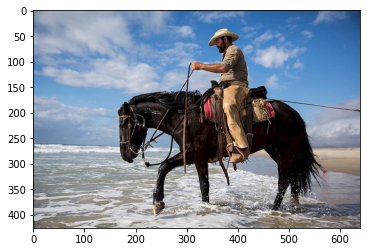

In [18]:
### Input image
img_file_path = CURR_DIR + 'data/cowboy-757575_640.jpg'
img = PIL.Image.open(img_file_path)
orig_img_width, orig_img_height = img.size
plt.imshow(img)
plt.show()

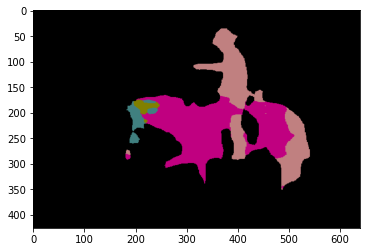

In [19]:
### Get color palette info (from arbitrary validation image)
root_path = CURR_DIR + 'data/VOCdevkit/VOC2012/'
_, _, _, val_anno_list = MakeDatapathList(root_path)
anno_flie_path = val_anno_list[0]
anno_class_img = PIL.Image.open(anno_flie_path)
color_palette_info = anno_class_img.getpalette()

### Image pre-processing
input_size = 475
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
data_transform = DataTransform(input_size, color_mean, color_std)
img, _ = data_transform('val', img, anno_class_img)

### Inference
net.eval()
x = img.unsqueeze(dim=0) ### Torch(3, 475, 475) ---> Torch(1, 3, 475, 475)
outputs, outputs_aux = net(x)

### Create segmentation result image with color plette
y = outputs[0].detach().numpy() ### Torch(1, 3, 475, 475) ---> Numpy(3, 475, 475)
y = np.argmax(y, axis=0)
anno_class_img = PIL.Image.fromarray(np.uint8(y), mode='P')
anno_class_img = anno_class_img.resize((orig_img_width, orig_img_height), PIL.Image.NEAREST)
anno_class_img.putpalette(color_palette_info)
plt.imshow(anno_class_img)
plt.show()

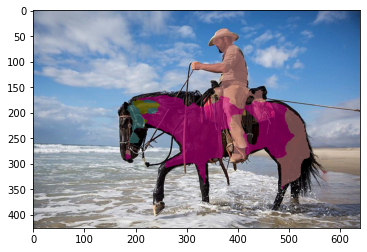

In [24]:
anno_class_img_rgba = PIL.Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
anno_class_img = anno_class_img.convert('RGBA')

for u in range(orig_img_width):
    for v in range(orig_img_height):
        r, g, b, a = anno_class_img.getpixel((u, v))
        if r != 0 or g != 0 or b != 0:
            a = 150
            anno_class_img_rgba.putpixel((u, v), (r, g, b, a))

img = PIL.Image.open(img_file_path)
result_img = PIL.Image.alpha_composite(img.convert('RGBA'), anno_class_img_rgba)
plt.imshow(result_img)
plt.show()